# Intro
This notebook analyzes CNN verification model performance. Unlike OCSVM and Catboost models, 
it is run directly on image pairs. 
Requriements: test image data and metdata in numpy form, produced by cnn/train.py script.

In [58]:
import sys
sys.path.insert(0, '../../')
import os
import pandas as pd
import cv2
import timeit
from sklearn.metrics import classification_report
import numpy as np
import glob
import random
from sklearn.metrics.pairwise import cosine_similarity
from machine_learning.cnn import create_model3, create_feature_extractor
from tensorflow.python.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import tensorflow as tf
import matplotlib
%matplotlib notebook
matplotlib.style.use('default')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [2]:
# load data
x_test = np.load('../../../data/x.npz.test.npz')
x_test = x_test.get(list(x_test.keys())[0])
y_test = np.load('../../../data/y.npz.test.npz')
y_test = y_test.get(list(y_test.keys())[0])
meta = pd.read_csv('../../../data/cnn_meta.csv')

In [28]:
# add fields
meta['filename'] = meta.master.str.extract('^.+/(.+)$')
meta['rend_type'] = meta.filename.str.extract('__[0-9]+__[0-9]+p_(.+)__[0-9]+\.?[0-9]+__[0-9]+')
meta['rend_res'] = meta.filename.str.extract('__[0-9]+__([0-9]+p)')
meta['tamper'] = y_test[..., 1]
meta['tamper_lab'] = meta.tamper > 0.5

In [29]:
meta.groupby('rend_type').rend_type.count().sort_values()

rend_type
watermark-345x114_25-24fps            8
rotate_90_clockwise_25-24fps          9
flip_horizontal_30-24fps_gpu          9
24-30fps                             10
watermark-345x114_30-60fps_gpu       10
watermark-345x114_25-60fps           10
vignette_30-60fps_gpu                10
vignette_25-60fps                    10
vignette_25-30fps_gpu                10
vignette_24-60fps_gpu                10
rotate_90_clockwise_30-60fps         10
rotate_90_clockwise_25-24fps_gpu     10
flip_vertical                        10
rotate_90_clockwise_24-30fps         10
black_and_white_25-60fps             10
24-30fps_gpu                         10
24-60fps                             10
24-60fps_gpu                         10
25-30fps                             10
25-60fps                             10
black_and_white_25-30fps             10
30-60fps_gpu                         10
watermark_30-24fps                   11
25-24fps                             17
rotate_90_counterclockwise    

In [68]:
def load_model():
    # load model
    model = create_model3()
    model.load_weights('../output/verifier_cnn.hdf5')
    return model
model = load_model()

In [33]:
# predict on test
y_pred = model.predict(x_test)
y_pred_lab = y_pred[..., 1]>0.2

In [34]:
print(classification_report(meta['tamper_lab'], y_pred_lab))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97      3147
        True       0.99      0.98      0.98      5027

    accuracy                           0.98      8174
   macro avg       0.97      0.98      0.98      8174
weighted avg       0.98      0.98      0.98      8174



In [35]:
print('Hardest renditions by type')
hard_rend = meta[np.logical_and(y_pred_lab!=meta.tamper_lab, meta.tamper_lab==1)].groupby('rend_type').rend_type.count().sort_values().tail(15)
print(hard_rend)

Hardest renditions by type
rend_type
vignette_30-60fps_gpu     1
vignette                  3
rotate_90_clockwise       4
watermark_30-24fps        5
watermark                 7
watermark-345x114         8
flip_horizontal          25
black_and_white          31
watermark-856x856        35
Name: rend_type, dtype: int64


<IPython.core.display.Javascript object>


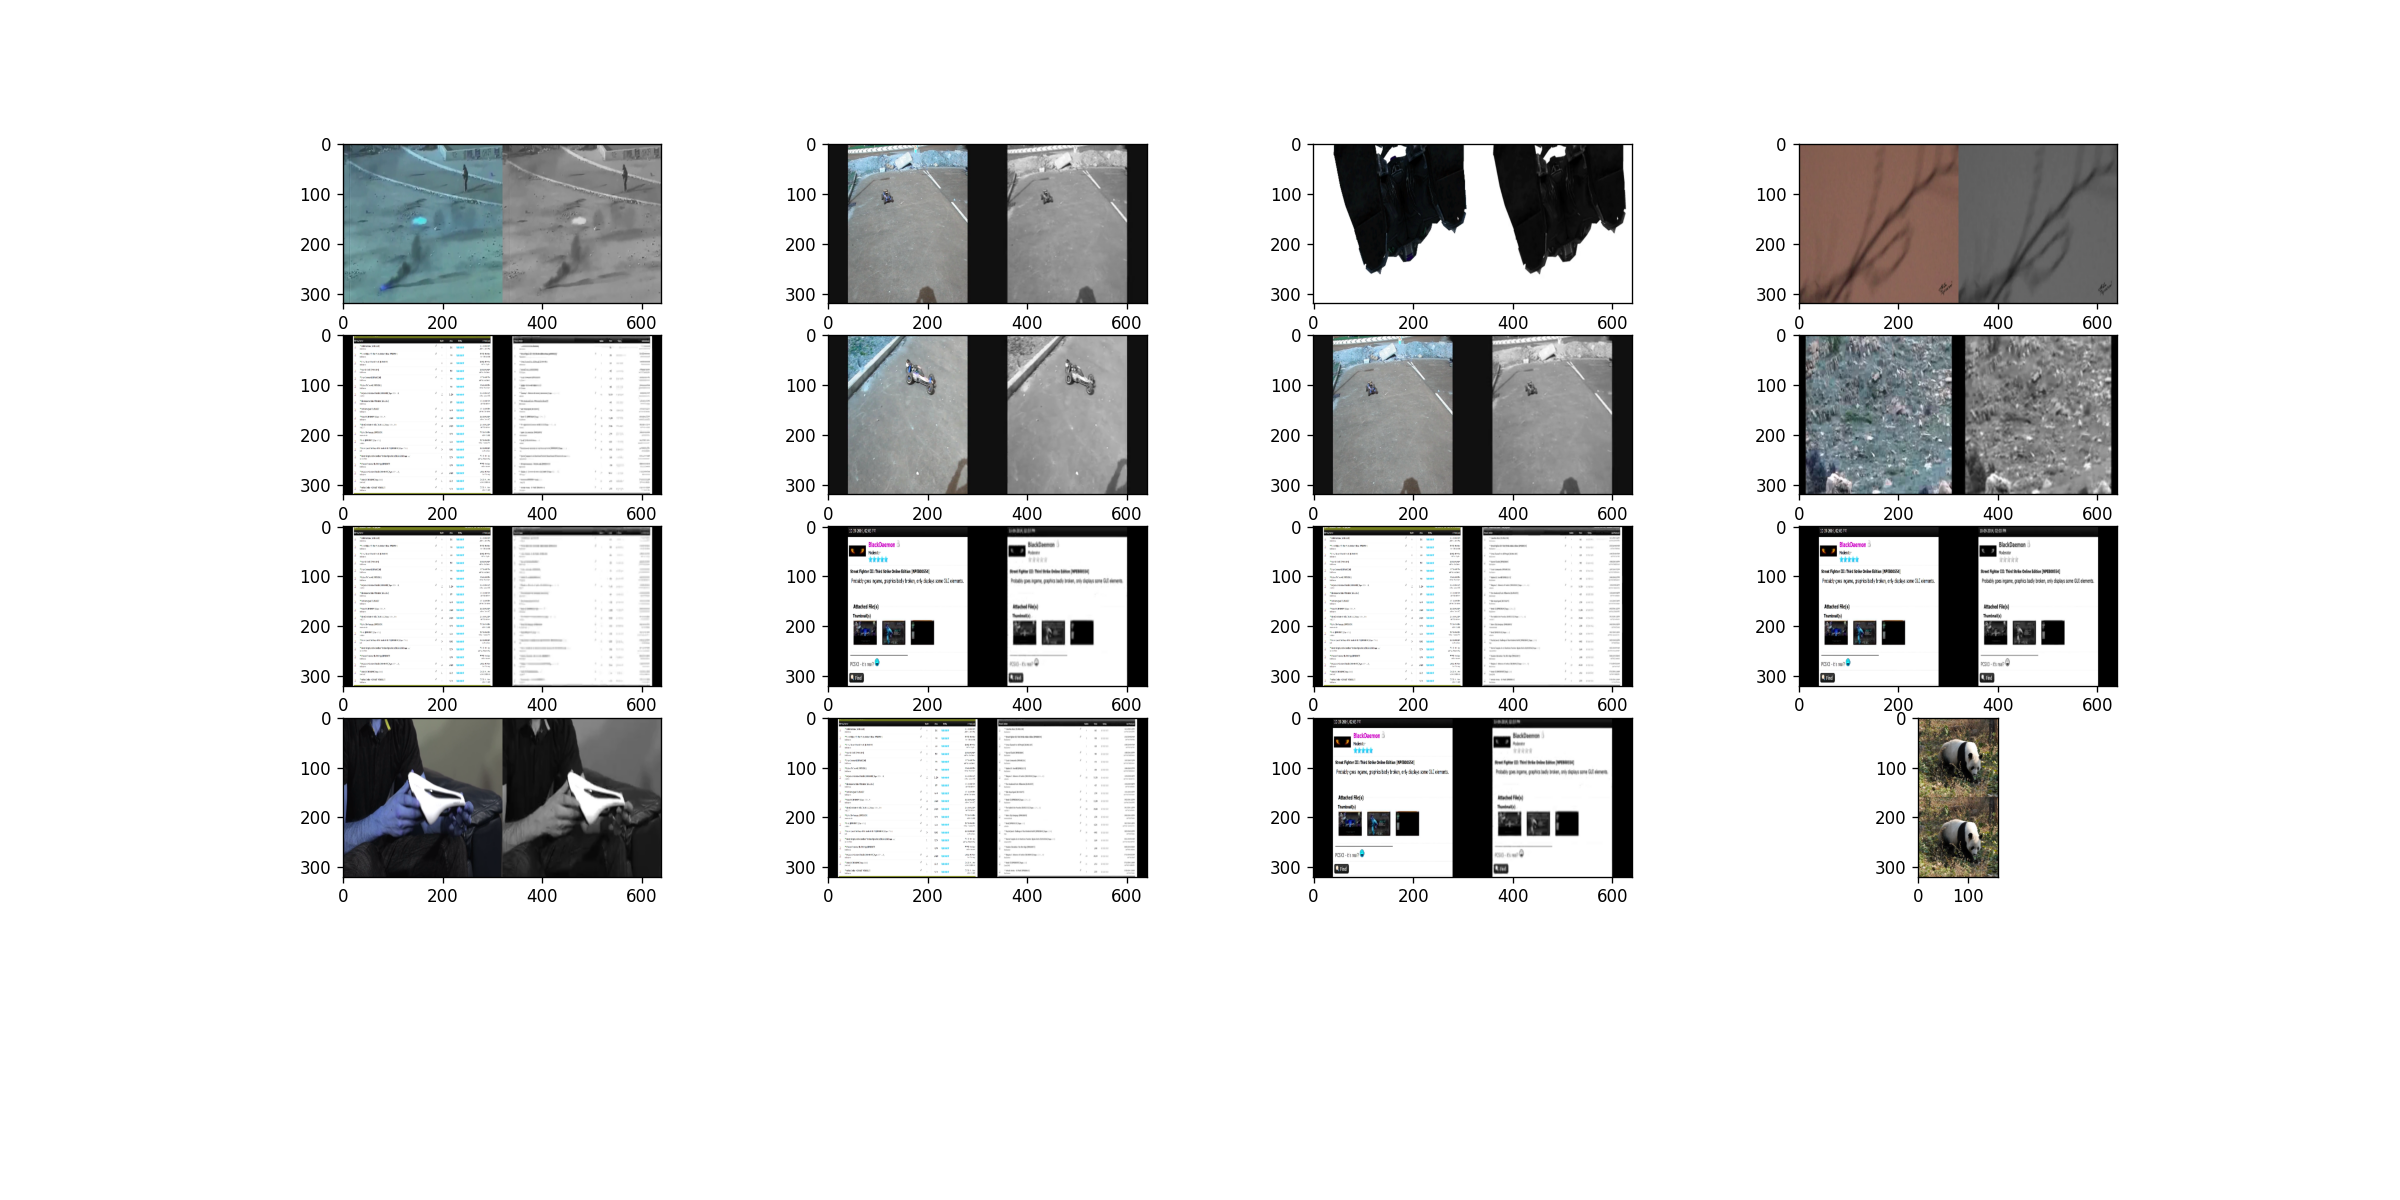

In [39]:
# show some of hardest type samples
hardest_type = hard_rend.index[-2]
hardest_idx = np.where(np.logical_and(np.logical_and(y_pred_lab!=meta.tamper_lab, meta.rend_type==hardest_type),
                                      meta.tamper_lab==1))[0]
plt.figure(figsize=(20,10))
columns = 4
n_imgs = 16
hardest_idx = hardest_idx[:n_imgs]
plot_num = 0
for i in hardest_idx:
    img1 = cv2.imread(meta.iloc[i].master)
    img2 = cv2.imread(meta.iloc[i].rendition)
    image = np.concatenate([img1, img2], axis=1)
    plt.subplot(n_imgs / columns + 1, columns, plot_num + 1)
    plt.imshow(image)
    plot_num+=1

In [55]:
# some sanity tests
#img1 = cv2.imread('../../testing/tests/data/fix_scene_move_1.png')[...,::-1]
#img2 = cv2.imread('../../testing/tests/data/fix_scene_move_2.png')[...,::-1]
#img1 = cv2.imread('../../testing/tests/data/panda.jpg')[...,::-1]
#img2 = cv2.imread('../../testing/tests/data/panda.jpg')[...,::-1]
img1 = cv2.imread('../../testing/tests/data/codec_impl_color_diff_2.png')[...,::-1]
img2 = cv2.imread('../../testing/tests/data/codec_impl_color_diff_1.png')[...,::-1]
img1 = cv2.resize(img1, (160, 160))
img2 = cv2.resize(img2, (160, 160))
img = preprocess_input(np.abs(img1-img2))
plt.imshow(np.concatenate([img1, img2], axis=0))
plt.show()
model.predict(img[None])[...,1]

array([0.88079196], dtype=float32)

<IPython.core.display.Javascript object>


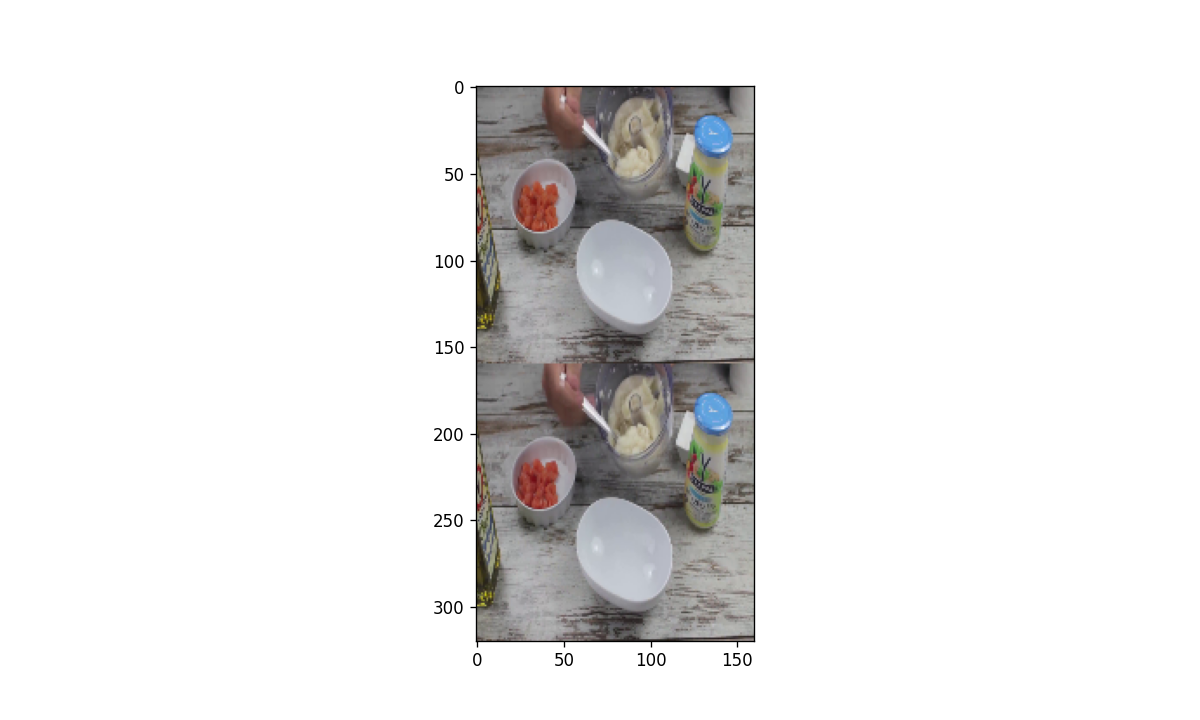

In [69]:
# Performance test
def test_on_device(dev='/cpu:0', n_samples=10):
    with tf.device(dev):
        # re-create model and warmup
        model = load_model()
        # warmup
        pred = model.predict(img[None])
        start = timeit.default_timer()
        pred = model.predict(np.array(n_samples*[img]))
        time = timeit.default_timer()-start
    print(f'Total time on devices {dev} for {n_samples}: {time}')
    print(f'Time per sample: {time/n_samples:.3f}')    

In [71]:
test_on_device(dev='/cpu:0')
test_on_device(dev='/gpu:0')

Total time on devices /cpu:0 for 10: 0.08274871899993741
Time per sample: 0.008
Total time on devices /gpu:0 for 10: 0.02039802299987059
Time per sample: 0.002
